In [10]:
import facebook as fb

import pandas as pd
from pandas import json_normalize
import numpy as np

import datetime as dt
import pytz

import seaborn as sns
import matplotlib.pyplot as plt

import os
from langchain.agents import create_pandas_dataframe_agent
from langchain.chat_models import ChatOpenAI
from langchain.llms import OpenAI

In [11]:
# Access token for the Facebook Graph API
access_token = "xxx"

In [31]:
# Fan page ID or username
page_ids = ['xxx' # more channels here
           ]

In [13]:
# Create a Facebook Graph API object
graph = fb.GraphAPI(access_token)

In [14]:
source_tz = 'UTC'  # Replace with your source time zone
target_tz = 'Asia/Bangkok'  # Replace with your target time zone

In [15]:
page_info_fields = 'id, name'

page_insights_fields_date_preset = 'last_90d'
page_insights_fields_period = 'day'
page_insights_fields_metric = 'page_engaged_users,page_post_engagements,page_impressions_organic_v2,page_impressions_organic_unique_v2,page_impressions_paid,page_impressions_paid_unique,page_posts_impressions_organic,page_posts_impressions_organic_unique,page_posts_impressions_paid,page_posts_impressions_paid_unique,page_fans,page_fan_adds,page_fan_adds_unique'
page_insights_fields = 'insights.date_preset({}).period({}).metric({})'.format(page_insights_fields_date_preset,page_insights_fields_period,page_insights_fields_metric)


post_analysis_date_preset = 'last_90d'
post_analysis_data = '{created_time,permalink_url,status_type,comments.summary(total_count),reactions.summary(total_count),shares,insights.metric(post_engaged_users,post_engaged_fan,post_clicks,post_clicks_unique,post_impressions,post_impressions_unique,post_impressions_fan,post_impressions_fan_unique)}'
post_analysis_fields = 'posts.date_preset({}){}'.format(post_analysis_date_preset, post_analysis_data)

In [16]:
def page_info(page_id, page_info_fields):
    page_info = pd.DataFrame()  # Initialize an empty list to store page information
    
    for page_id in page_ids:  # Loop through the page_ids (assuming it is defined outside the function)
        page_info_graph = graph.get_object(id = page_id, fields = page_info_fields)  # Fetch the page information using the provided page_id
        page_info_element = graph.get_object(id = page_id, fields = page_info_fields)
        page_info_element = json_normalize(page_info_element)
        page_info = pd.concat([page_info, page_info_element], axis = 0)
    
    return page_info  # Return the resulting DataFrame containing the page information


In [17]:
page_info_df = page_info(page_ids, page_info_fields)
print(page_info_df.head())

                id                         name
0  982493555096370  KOC - Nhà Leo Núi Tương Lai


In [89]:
def page_insights(page_ids, page_insights_fields):
    page_insights = pd.DataFrame()  # Create an empty dataframe to store page insights
        
    for page_id in page_ids:
        page_insights_element = graph.get_object(id=page_id, fields=page_insights_fields)
        page_insights_element = json_normalize(page_insights_element['insights']['data'], record_path='values', meta=['name', 'period'])
        page_insights_element = page_insights_element.pivot(index='end_time', columns='name', values='value')
        page_insights_element.reset_index(inplace=True)
        page_insights_element['page_id'] = page_id  # Add 'page_id' column
        if len(page_insights) == 0:
            page_insights = page_insights_element
        else:
            page_insights = pd.concat([page_insights, page_insights_element], axis=0)
            
    # Rename the 'end_date' column to 'date'
    page_insights = page_insights.rename(columns={'end_time': 'date'})
    page_insights['date'] = pd.to_datetime(page_insights['date']) - pd.Timedelta(days=1)
    page_insights['date'] = page_insights['date'].dt.strftime("%d/%m/%Y") 
    page_insights['date'] = pd.to_datetime(page_insights['date'], format= '%d/%m/%Y')
    return page_insights  # Return the final page insights DataFrame

In [90]:
page_insights_df = page_insights(page_ids, page_insights_fields)
page_insights_df.head()

name,date,page_engaged_users,page_fan_adds,page_fan_adds_unique,page_fans,page_impressions_organic_unique_v2,page_impressions_organic_v2,page_impressions_paid,page_impressions_paid_unique,page_post_engagements,page_posts_impressions_organic,page_posts_impressions_organic_unique,page_posts_impressions_paid,page_posts_impressions_paid_unique,page_id
0,2023-02-27,7,0,0,5309,78,219,0,0,12,219,78,0,0,982493555096370
1,2023-02-28,6,1,1,5308,80,177,0,0,5,174,78,0,0,982493555096370
2,2023-03-01,10,0,0,5307,81,236,0,0,13,236,81,0,0,982493555096370
3,2023-03-02,46,1,1,5306,271,383,0,0,61,383,271,0,0,982493555096370
4,2023-03-03,11,0,0,5306,130,244,0,0,18,244,130,0,0,982493555096370


In [21]:
def post_analysis(page_ids, post_analysis_fields):
    post_analysis_list = []  # Initialize an empty list to store post analysis information
    post_analysis_dict = {}  # Initialize an empty dictionary for post analysis
    post_analysis_dict_list = []  # Initialize an empty list to store dictionaries
    
    for page_id in page_ids:
        post_analysis_graph = graph.get_object(id=page_id, fields=post_analysis_fields)
        post_analysis_list.append(post_analysis_graph)  # Append post analysis graph of each id to the list
    
    for i in post_analysis_list:
        for k in i['posts']['data']:
            post_analysis_dict = {'page_id': i['id'], 'post_id': k['id'],'created_time': k['created_time'], 'permalink_url': k['permalink_url'], 'status_type': k['status_type'], 'total_comment': k['comments']['summary']['total_count'], 'total_reactions': k['reactions']['summary']['total_count']}
            
            for l in k['insights']['data']:
                post_analysis_dict[l['name']] = l['values'][0]['value']  # Add insights data to the dictionary
            
            post_analysis_dict_list.append(post_analysis_dict)  # Append the dictionary to the list
        
    post_analysis = pd.DataFrame(post_analysis_dict_list)  # Create a DataFrame from the list of dictionaries
    
    post_analysis['created_time'] = pd.to_datetime(post_analysis['created_time']).dt.tz_convert(target_tz) # Convert 'created_time' column to datetime
    
    return post_analysis  # Return the resulting DataFrame containing the post analysis information


In [22]:
post_analysis_df = post_analysis(page_ids, post_analysis_fields)
post_analysis(page_ids, post_analysis_fields).head(10)

,page_id,post_id,created_time,permalink_url,status_type,total_comment,total_reactions,post_engaged_users,post_engaged_fan,post_clicks,post_clicks_unique,post_impressions,post_impressions_unique,post_impressions_fan,post_impressions_fan_unique
0,982493555096370,982493555096370_6682167961795539,2023-05-19 12:18:07+07:00,https://www.facebook.com/982493555096370/posts...,added_photos,1,50,79,59,63,41,690,634,408,373
1,982493555096370,982493555096370_6638005312878471,2023-05-06 20:00:17+07:00,https://www.facebook.com/982493555096370/posts...,added_photos,27,98,900,429,2388,876,5373,3975,1841,1133
2,982493555096370,982493555096370_6634489569896712,2023-05-05 20:58:02+07:00,https://www.facebook.com/982493555096370/posts...,added_photos,15,169,1597,678,4802,1535,11844,8359,3978,1777
3,982493555096370,982493555096370_6621949497817386,2023-05-02 08:10:55+07:00,https://www.facebook.com/982493555096370/posts...,added_photos,0,93,300,222,413,245,1457,1198,845,636
4,982493555096370,982493555096370_6620290271316642,2023-05-01 20:30:40+07:00,https://www.facebook.com/982493555096370/posts...,added_photos,9,57,155,109,220,114,2098,1682,829,580
5,982493555096370,982493555096370_6619223554756647,2023-05-01 12:30:09+07:00,https://www.facebook.com/982493555096370/posts...,added_photos,15,43,172,127,288,151,1854,1537,742,547
6,982493555096370,982493555096370_6616014678410868,2023-04-30 12:15:38+07:00,https://www.facebook.com/982493555096370/posts...,added_photos,13,51,149,96,216,115,1709,1440,711,530
7,982493555096370,982493555096370_6611056595573343,2023-04-29 00:02:19+07:00,https://www.facebook.com/982493555096370/posts...,added_photos,10,49,141,96,152,98,2004,1688,753,551
8,982493555096370,982493555096370_6607724075906595,2023-04-28 00:01:01+07:00,https://www.facebook.com/982493555096370/posts...,added_photos,19,63,141,107,149,90,1810,1466,704,485
9,982493555096370,982493555096370_6603917749620561,2023-04-26 20:21:37+07:00,https://www.facebook.com/982493555096370/posts...,added_video,21,74,195,124,295,150,1977,1510,761,455


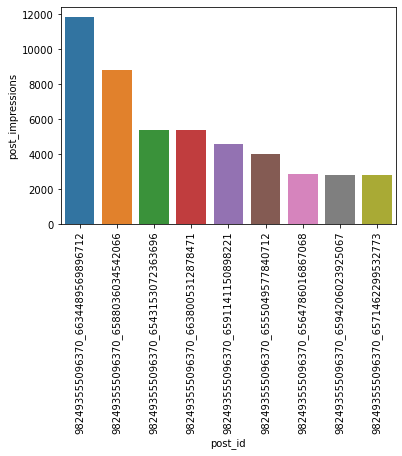

In [23]:
ax = sns.barplot(x = 'post_id', y = 'post_impressions', data = post_analysis_df.sort_values('post_impressions', ascending = False)[0:9])
plot = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

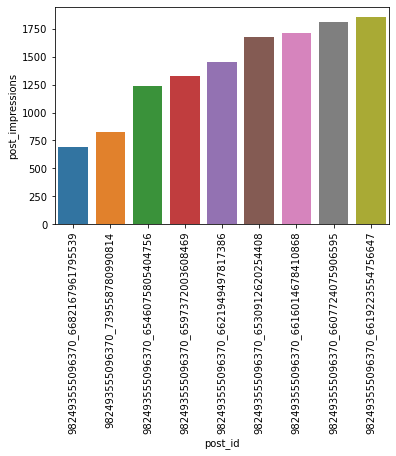

In [24]:
ax = sns.barplot(x = 'post_id', y = 'post_impressions', data = post_analysis_df.sort_values('post_impressions', ascending = True)[0:9])
plot = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

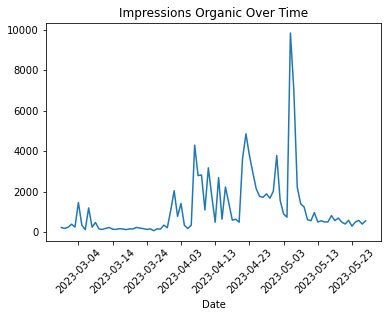

In [103]:
sns.lineplot(x = 'date', y = 'page_impressions_organic_v2', data = page_insights_df)

plt.title('Impressions Organic Over Time')
plt.xlabel('Date')
plt.ylabel('')

plt.xticks(rotation=45)
ax = plt.gca()
ax.xaxis.set_major_locator(plt.MaxNLocator(10))

plt.show()

In [27]:
os.environ["OPENAI_API_KEY"] = 'sk-XXXX'

In [28]:
agent = create_pandas_dataframe_agent(OpenAI(temperature=0), post_analysis_df, verbose=True)

In [29]:
def chatbot():
    while True:
        # Prompt the user for input
        user_input = input('You: ')

        # Check if user input is not "end" (case-insensitive)
        if user_input.lower() not in ["end", "End"]:
            # Call the agent's run method to process user input
            agent.run(user_input)
        else:
            # Break the loop if user input is "end" or "End"
            break
